## Binary Classification of ALL cancer cells
- Folder composition
    - testing_data
    - training_data
    - validation_data

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
# from keras.utils import np_utils

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

#sklearn libraries
from sklearn.model_selection import train_test_split

#tensorflow libraries
import tensorflow as tf
from tensorflow.keras.initializers import RandomNormal
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import cv2


### Importing Training Data
- Class 0 = ALL (cancer)
- Class 1 = Normal 

In [48]:
data_dir = 'C-NMC_Leukemia/training_data'


# define the paths in the training_data folder
files = []
classes = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)

    for fold_ in filelist:
        foldpath_ = os.path.join(foldpath, fold_)
        filelist_ = os.listdir(foldpath_)

        for file_ in filelist_:
            fpath = os.path.join(foldpath_, file_)
            files.append(fpath)
            classes.append(fold_)
# path to easy individual files 

In [4]:
# Concatenate data paths with labels into one dataframe ( to later be fitted into the model
Fseries = pd.Series(files, name= 'filepaths')
Lseries = pd.Series(classes, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)
df

,filepaths,labels
0,C-NMC_Leukemia/training_data/fold_2/hem/UID_H4...,hem
1,C-NMC_Leukemia/training_data/fold_2/hem/UID_H4...,hem
2,C-NMC_Leukemia/training_data/fold_2/hem/UID_H4...,hem
3,C-NMC_Leukemia/training_data/fold_2/hem/UID_H1...,hem
4,C-NMC_Leukemia/training_data/fold_2/hem/UID_H2...,hem
...,...,...
10656,C-NMC_Leukemia/training_data/fold_1/all/UID_38...,all
10657,C-NMC_Leukemia/training_data/fold_1/all/UID_34...,all
10658,C-NMC_Leukemia/training_data/fold_1/all/UID_30...,all
10659,C-NMC_Leukemia/training_data/fold_1/all/UID_51...,all


In [5]:
strat = df['labels']
train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=123, stratify=strat)

# test dataframe   
strat = dummy_df['labels']
valid_df, test_df= train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

In [6]:
    batch_size = 40
    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    # no data augmentation
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

Found 7462 validated image filenames belonging to 2 classes.
Found 1599 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.


In [7]:
print(f'Train: X={train_df.shape} ')
print(f'Test: X={test_df.shape}')
print(f'Validation: X={valid_df.shape}')

Train: X=(7462, 2) 
Test: X=(1600, 2)
Validation: X=(1599, 2)


{'all': 0, 'hem': 1}
['all', 'hem']


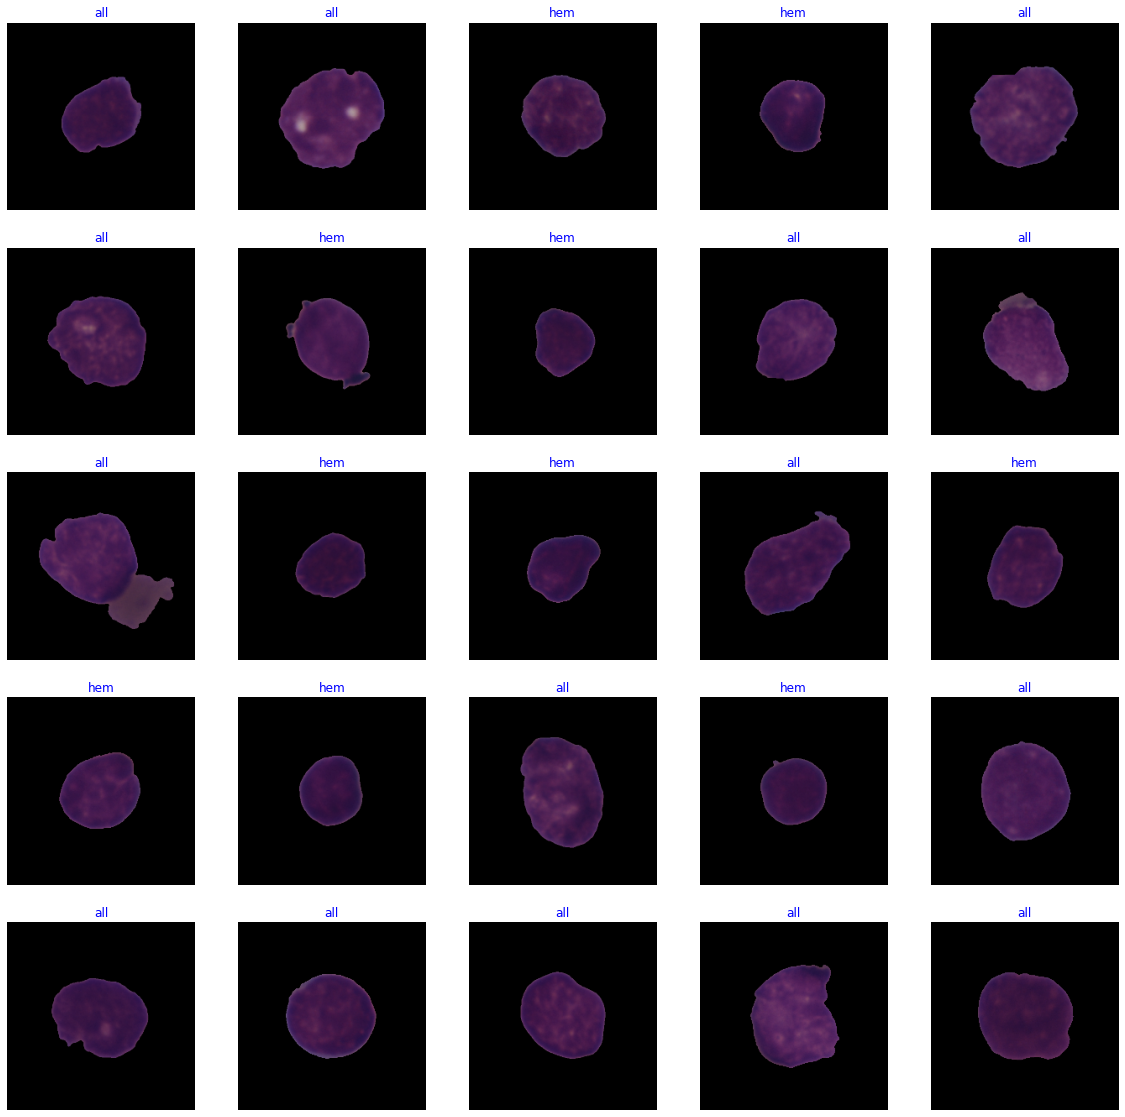

In [8]:
# display sample images from training  

g_dict = train_gen.class_indices        # defines dictionary {'class': index}
print(g_dict)
classes = list(g_dict.keys()) # defines list of dictionary's kays (classes), classes names : string
print(classes)
images, labels = next(train_gen)        # get a batch size samples from the generator

# calculate number of displayed samples
length = len(labels)        # length of batch size
sample = min(length, 25)    # check if sample less than 25 images

plt.figure(figsize= (20, 20))

for i in range(sample):
    plt.subplot(5, 5, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [9]:
from keras.layers import Activation, Dense
from keras.models import Sequential 

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
model = Sequential([
    base_model,
    Dense(2, activation= 'softmax')
])

# model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 dense (Dense)               (None, 2)                 3074      
                                                                 
Total params: 10,786,609
Trainable params: 10,699,306
Non-trainable params: 87,303
_________________________________________________________________


In [10]:
training = model.fit(x= train_gen, epochs= 5, verbose= True,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Epoch 1/5
187/187 [==============================] - 2188s 12s/step - loss: 1.2050 - accuracy: 0.8026 - val_loss: 1.0861 - val_accuracy: 0.7223
Epoch 2/5
187/187 [==============================] - 2226s 12s/step - loss: 0.3205 - accuracy: 0.8747 - val_loss: 0.4792 - val_accuracy: 0.7705
Epoch 3/5
187/187 [==============================] - 2198s 12s/step - loss: 0.2596 - accuracy: 0.8951 - val_loss: 0.6157 - val_accuracy: 0.6879
Epoch 4/5
187/187 [==============================] - 2091s 11s/step - loss: 0.2221 - accuracy: 0.9125 - val_loss: 0.3400 - val_accuracy: 0.8543
Epoch 5/5
187/187 [==============================] - 2190s 12s/step - loss: 0.1951 - accuracy: 0.9251 - val_loss: 0.5274 - val_accuracy: 0.7530


In [12]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_pred

20/20 [==============================] - 83s 4s/step


array([1, 0, 1, ..., 1, 1, 0])

0.761875


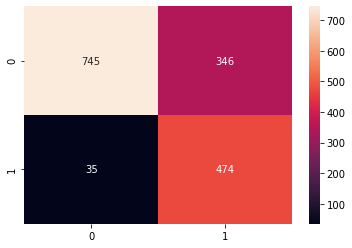

In [14]:
#confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(test_gen.classes, y_pred)

sns.heatmap(cm, annot=True,annot_kws={"size": 10},fmt="d")
print(accuracy_score(test_gen.classes, y_pred))

In [17]:
# Classification report
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
from sklearn.metrics import classification_report
print(classification_report(test_gen.classes, y_pred,target_names= classes))

              precision    recall  f1-score   support

         all       0.96      0.68      0.80      1091
         hem       0.58      0.93      0.71       509

    accuracy                           0.76      1600
   macro avg       0.77      0.81      0.75      1600
weighted avg       0.84      0.76      0.77      1600



In [35]:
# print(len(test_gen.classes))
test_arr = np.array(test_gen.classes)
# print(y_pred.type)
pd.crosstab(test_arr, y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Predicted,0,1,All
Actual,,,
0,745,346,1091
1,35,474,509
All,780,820,1600


In [39]:
g_dict = test_gen.class_indices
g_dict

{'all': 0, 'hem': 1}

In [47]:
from sklearn.metrics import  roc_auc_score
uc_roc = roc_auc_score(test_gen.classes, y_pred, multi_class='ovr')
uc_roc

0.8070487413540686